# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/XianNg24/XianNg24.github.io/main/sketcher/mini_classes.txt'

--2022-01-27 03:02:09--  https://raw.githubusercontent.com/XianNg24/XianNg24.github.io/main/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2378 (2.3K) [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]   2.32K  --.-KB/s    in 0s      

2022-01-27 03:02:09 (49.7 MB/s) - ‘mini_classes.txt’ saved [2378/2378]



Read the classes names 

In [3]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [2]:
!rm -rf data

In [5]:
!mkdir data

In [6]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/alarm%20clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/arm.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/backpack.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bandage.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/barn.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bi

# Imports 

In [8]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 2000 images per class.  

In [9]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 2200 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        # print(data.shape)
        data = data[0: max_items_per_class, :]
        # print(data.shape)
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [11]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [12]:
print(len(x_train))

528000


Show some random data 

horse


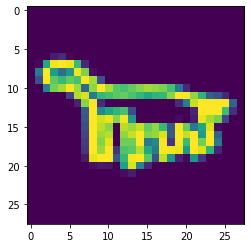

In [13]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [14]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [18]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(128, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))            
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Convolution2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Convolution2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Convolution2D(1024, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(1024, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(300, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy', 'top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 256)      

# Training 

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_top_k_categorical_accuracy', mode='max', patience=3)
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=15, callbacks=[callback],)

Epoch 1/15
1857/1857 [==============================] - 298s 160ms/step - loss: 2.1709 - accuracy: 0.4880 - top_k_categorical_accuracy: 0.7536 - val_loss: 1.6992 - val_accuracy: 0.5836 - val_top_k_categorical_accuracy: 0.8382
Epoch 2/15
1857/1857 [==============================] - 299s 161ms/step - loss: 1.4178 - accuracy: 0.6421 - top_k_categorical_accuracy: 0.8752 - val_loss: 1.4277 - val_accuracy: 0.6408 - val_top_k_categorical_accuracy: 0.8742
Epoch 3/15
1857/1857 [==============================] - 299s 161ms/step - loss: 1.2120 - accuracy: 0.6886 - top_k_categorical_accuracy: 0.9001 - val_loss: 1.3200 - val_accuracy: 0.6694 - val_top_k_categorical_accuracy: 0.8876
Epoch 4/15
1857/1857 [==============================] - 299s 161ms/step - loss: 1.0630 - accuracy: 0.7213 - top_k_categorical_accuracy: 0.9168 - val_loss: 1.2485 - val_accuracy: 0.6917 - val_top_k_categorical_accuracy: 0.8960
Epoch 5/15
1857/1857 [==============================] - 298s 161ms/step - loss: 0.9304 - accurac

In [20]:
def get_classes_accuracy(x_test, y_test):
    # Get predictions
    y_pred = model.predict(x_test)
    # Get top five predictions' indexes for each images 
    pred_sorted = y_pred.argsort(axis=1)[:,-5:][:,::-1]
    # Get indexes from y_test
    y_sorted = y_test.argmax(axis=1)
    # Get if predictions fall under top five results
    preds = np.array([np.any(element == pred_sorted[idx]) for idx, element in enumerate(y_sorted)])
    # Calculate the accuracy of each class
    store = np.zeros(300)
    for idx, element in enumerate(preds):
      if(element == True):
        store[y_sorted[idx]] += 1
    (unique, counts) = np.unique(y_sorted, return_counts=True)
    for idx, element in enumerate(store):
        store[idx] = store[idx] * 100 / counts[idx]
    label_dict = {}
    for idx, element in enumerate(class_names):
      label_dict[element] = round(store[idx], 4)
    # Sort the results
    return sorted(label_dict.items(), key=lambda x: x[1], reverse=True)

In [21]:
classes_accuracy = get_classes_accuracy(x_test, y_test)
classes_accuracy

[('bicycle', 98.5366),
 ('rainbow', 97.9592),
 ('ladder', 97.1047),
 ('t-shirt', 97.0852),
 ('skateboard', 96.7213),
 ('snail', 96.696),
 ('circle', 96.5278),
 ('pineapple', 96.4953),
 ('triangle', 96.3387),
 ('hourglass', 96.25),
 ('butterfly', 96.2222),
 ('giraffe', 96.2138),
 ('sweater', 96.1995),
 ('ice_cream', 96.0251),
 ('zigzag', 95.9368),
 ('house', 95.9276),
 ('tent', 95.8025),
 ('pants', 95.7399),
 ('wheel', 95.6422),
 ('The_Eiffel_Tower', 95.4545),
 ('shorts', 95.3086),
 ('snowman', 95.302),
 ('clock', 95.2809),
 ('umbrella', 95.2381),
 ('police_car', 95.2153),
 ('sun', 95.1724),
 ('star', 95.122),
 ('microwave', 95.122),
 ('headphones', 95.0959),
 ('donut', 95.0472),
 ('cookie', 95.0355),
 ('windmill', 95.0119),
 ('sailboat', 95.0119),
 ('bucket', 94.9561),
 ('ocean', 94.9425),
 ('radio', 94.9309),
 ('crown', 94.8357),
 ('mountain', 94.6548),
 ('pear', 94.6512),
 ('fish', 94.6352),
 ('picture_frame', 94.5626),
 ('flamingo', 94.533),
 ('birthday_cake', 94.4828),
 ('camera', 

# Testing 

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[2] * 100))

Test accuarcy: 88.90%


# Inference 

['crown', 'mountain', 'grass', 'tooth', 'castle']


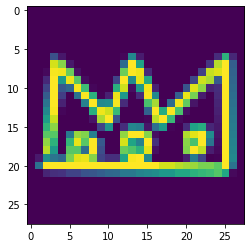

In [23]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [24]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [25]:
!pip install tensorflowjs 

     |████████████████████████████████| 77 kB 3.8 MB/s 


# Save and Convert 

In [26]:
model.save('keras.h5')

In [27]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [28]:
!cp class_names.txt model/class_names.txt

In [29]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard8of23.bin (deflated 7%)
  adding: model/group1-shard4of23.bin (deflated 7%)
  adding: model/group1-shard17of23.bin (deflated 7%)
  adding: model/group1-shard18of23.bin (deflated 7%)
  adding: model/group1-shard2of23.bin (deflated 7%)
  adding: model/group1-shard16of23.bin (deflated 7%)
  adding: model/group1-shard3of23.bin (deflated 7%)
  adding: model/group1-shard15of23.bin (deflated 7%)
  adding: model/group1-shard19of23.bin (deflated 8%)
  adding: model/group1-shard13of23.bin (deflated 7%)
  adding: model/group1-shard10of23.bin (deflated 7%)
  adding: model/group1-shard11of23.bin (deflated 7%)
  adding: model/group1-shard14of23.bin (deflated 7%)
  adding: model/group1-shard12of23.bin (deflated 7%)
  adding: model/group1-shard1of23.bin (deflated 7%)
  adding: model/group1-shard5of23.bin (deflated 7%)
  adding: model/class_names.txt (deflated 44%)
  adding: model/group1-shard20of23.bin (deflated 7%)
  adding: model/group1-shard2

In [30]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>